# Prediction Power plant run time
based on:
- solar power
- wind power
- energy spot price
- grid load

In [1]:
import json
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn import svm
from sklearn.metrics import accuracy_score,r2_score
import matplotlib.pyplot as plt
from scipy.optimize import minimize

import pysolar.solar as psl
from datetime import datetime, timezone, timedelta
from math import cos,pi

from influxdb import InfluxDBClient, DataFrameClient

import warnings
warnings.filterwarnings('ignore')

## Configuration setup

In [2]:
config_file = "/Users/privateUser/Project/src/config.json"
with open(config_file,'r') as f:
    config = json.load(f)

connection = config['influxDB_Power']['connection']['external']
#connection = config['influxDB_Power']['connection']['internal']

clientDF = DataFrameClient(**connection)

In [3]:
titlefont={'size':15,'weight':'bold'}
axisfont ={'size':12,'weight':'bold'}

In [4]:
# enable to allow commits to DB
commitToDB = False

### Start and end time of queries

In [5]:
# the start and end of the 'current time' predicition (data should exist for this period for power)
startTime = '2019-08-01 00:00:00'
endTime = '2019-08-20 00:00:00'

In [6]:
# the number of hours in the future to forecast
forecastHours = 48   # 1 day ahead of time

In [7]:
# use possible config definitions
if config.get('jupyter_SolarWindEnergy'):
    startTime = config['jupyter_SolarWindEnergy'].get('startTime')\
                if config['jupyter_SolarWindEnergy'].get('startTime') else startTime
    
    endTime = config['jupyter_SolarWindEnergy'].get('endTime')\
                if config['jupyter_SolarWindEnergy'].get('endTime') else endTime
    
    forecastHours = config['jupyter_SolarWindEnergy'].get('forecastHours')\
                if config['jupyter_SolarWindEnergy'].get('forecastHours') else forecastHours
    

In [8]:
# the forecast time 
fstartTime = endTime
ftemp = datetime.strptime(fstartTime,"%Y-%m-%d %H:%M:%S") + timedelta(hours=forecastHours)
fendTime = datetime.strftime(ftemp,"%Y-%m-%d %H:%M:%S")
faheadStr = f"_-{forecastHours}"
assert forecastHours % 3 == 0, "Error: forecast hours is only valid in multiples of 3 hours"

### configure cities for weather and solar queries

In [9]:
res = clientDF.query('''show field keys from climate..Global_radiation''')

In [10]:
# cities to use
ignore = ['year','month','weekday','holiday','hour','minute','Ø']
cities=[ v['fieldKey'] for v in list(res)[0] if v['fieldKey'] not in ignore]
print(",".join(cities))

Bremen,Chemnitz,Fichtelberg,Furstenzell,Gorlitz,Hamburg,Hohenpeissenberg,Konstanz,Lindenberg,Norderney,Potsdam,Rostock,Saarbrucken,Schleswig,Seehausen,Trier,Wuerzburg


In [11]:
# only the coordinate meta-data is actually needed here
weatherFile = "/Users/privateUser/Project/data/WeatherData/curr_20190701_002505.json"
with open(weatherFile,'r') as f:
    currWeather = json.load(f)
    
def getRadiativeIndex(city,date):
    longitude = currWeather[city]['coord']['lon']
    latitude  = currWeather[city]['coord']['lat']
    altitude_deg = psl.get_altitude(latitude,longitude,date)
    return psl.radiation.get_radiation_direct(date,altitude_deg)

# Create base solar radiation information

## Calculate radiative power

In [12]:
radcalc = pd.DataFrame(columns=cities,index=pd.date_range(start=startTime,end=fendTime,freq='15min',tz='UTC'))

In [13]:
for ct in cities:
    radcalc[ct] = radcalc.index.map(lambda x: getRadiativeIndex(ct,x + timedelta(hours=-2)))

Text(0, 0.5, 'Radiative Flux (W/m**2)')

<Figure size 432x288 with 0 Axes>

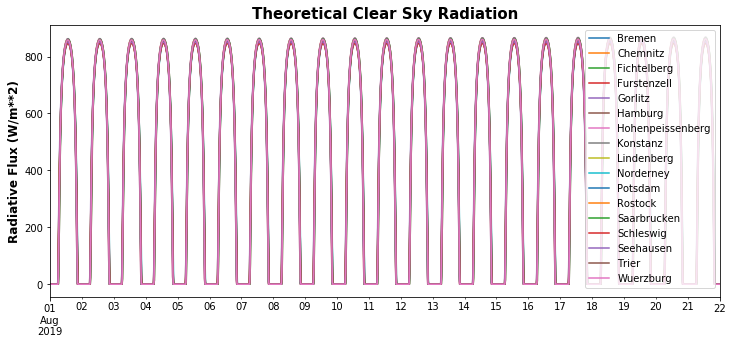

In [14]:
plt.figure()
radcalc.plot(figsize=(12,5))
plt.title("Theoretical Clear Sky Radiation",fontdict=titlefont)
plt.xlabel('',fontdict=axisfont)
plt.ylabel("Radiative Flux (W/m**2)",fontdict=axisfont)

## Query Weather
- based on city, determine the cloudiness to be used with the solar index

In [15]:
# current weather, up until the 'endTime'
# future weather is taken til 'fendTime'
citiesCSV = ",".join([ f'currentWeather.."wc-{ct}"' for ct in cities])
queryStatement = f"""\
 SELECT "clouds" FROM {citiesCSV} \
                    WHERE time >= '{startTime}' \
                    AND time <= '{endTime}'"""
#print(queryStatement)
res = clientDF.query(queryStatement)

In [16]:
currIndex = radcalc.index[radcalc.index <= endTime]
foreIndex = radcalc.index[radcalc.index > endTime]
cloudsbase = pd.DataFrame(index=currIndex)


In [17]:
for ct in cities:
    cloudsbase = cloudsbase.join(pd.DataFrame({ ct:res['wc-' + ct].clouds}),how='outer')

cloudsbase = cloudsbase.interpolate(limit_direction='both')
cloudsbase = cloudsbase.iloc[cloudsbase.index.isin(currIndex)]

In [18]:
# same query, almost, but for the future
citiesCSV = ",".join([ f'forecastWeather.."wf-{ct}{faheadStr}"' for ct in cities])
queryStatement = f"""\
 SELECT "clouds" FROM {citiesCSV} \
                    WHERE time >= '{fstartTime}' \
                    AND time <= '{fendTime}'"""
#print(queryStatement)
res = clientDF.query(queryStatement)

In [19]:
cloudsbasef = pd.DataFrame(index=foreIndex)
for ct in cities:
    cloudsbasef = cloudsbasef.join(pd.DataFrame({ ct:res[f"wf-{ct}{faheadStr}"].clouds}),how='outer')
    
cloudsbasef = cloudsbasef.interpolate(limit_direction='both')
cloudsbasef = cloudsbasef.iloc[cloudsbasef.index.isin(foreIndex)]

cloudsall = cloudsbase.append(cloudsbasef)


In [20]:
# stitch together at interface
cloudsall.loc[cloudsbase.index[-1]] = (cloudsall.loc[cloudsbase.index[-1]] + cloudsall.loc[cloudsbasef.index[0]])/2

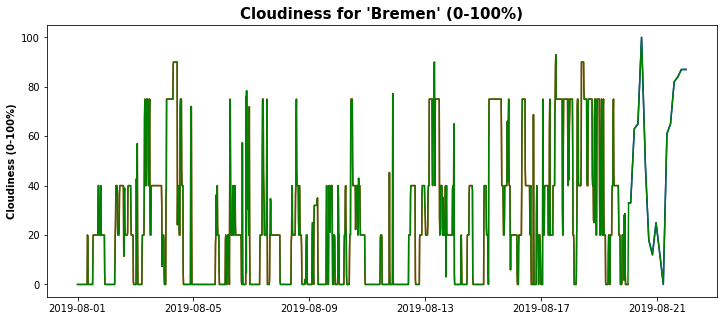

In [21]:
fig = plt.figure(figsize=(12,5))
plt.title("Cloudiness for \'Bremen\' (0-100%)",fontdict={'size': 15,'weight':'bold'})
plt.ylabel("Cloudiness (0-100%)",fontdict={'weight':'bold'})
plt.plot(cloudsbase.index ,cloudsbase.Bremen,'r-',
         cloudsbasef.index,cloudsbasef.Bremen,'b-',
         cloudsall.index  ,cloudsall.Bremen, 'g-')

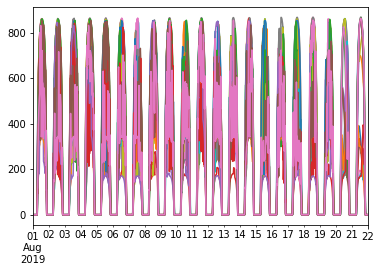

In [22]:
radPredict = pd.DataFrame()
for ct in cities:
    radPredict[ct] = (((100-cloudsall[ct])/100)*0.8 + 0.2)*radcalc[ct]
    
# predicted solar radiation 
radPredict.plot(legend=False)

# Correlate solar flux with power production
## Evaluation using collected Solar power net providers

In [23]:
database = 'power..solar_wind'

In [24]:
# select the measurements from the 'power' database for "Solar...".  Don't trust the average that they supply
res = clientDF.query(f'''show field keys from {database}''')

In [25]:
sources = [ v['fieldKey'] for v in list(res)[0] if v['fieldKey'].startswith("Solar")]
sources

['Solar 50Hertz', 'Solar Amprion', 'Solar Tennet', 'Solar Transnet BW']

In [26]:
sourcesCSV = ",".join([ f'"{sr}"' for sr in sources])
queryStatement = f"""\
 SELECT {sourcesCSV} FROM {database} \
                    WHERE time >= '{startTime}' \
                    AND time <= '{endTime}'"""
print(queryStatement)

 SELECT "Solar 50Hertz","Solar Amprion","Solar Tennet","Solar Transnet BW" FROM power..solar_wind                     WHERE time >= '2019-08-01 00:00:00'                     AND time <= '2019-08-20 00:00:00'


In [27]:
res = clientDF.query(queryStatement)

In [28]:
solarPower = res[list(res.keys())[0]]
solarPower.head()

,Solar 50Hertz,Solar Amprion,Solar Tennet,Solar Transnet BW
2019-08-01 00:00:00+00:00,0.0,0.0,0.0,0.0
2019-08-01 00:15:00+00:00,0.0,0.0,0.0,0.0
2019-08-01 00:30:00+00:00,0.0,0.0,0.0,0.0
2019-08-01 00:45:00+00:00,0.0,0.0,0.0,0.0
2019-08-01 01:00:00+00:00,0.0,0.0,0.0,0.0


In [29]:
solarPower['power'] = solarPower.sum(axis=1)

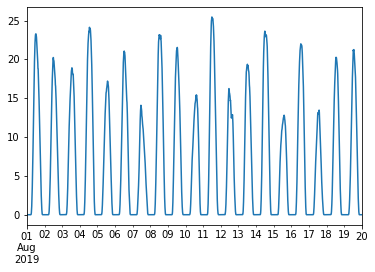

In [30]:
solarPower.power.plot()

## Evaluation using Solar power stored in 'price' database 
- price..general{solar}

In [31]:
database = 'price..general'

In [32]:
fieldKey = '"Solar"'
queryStatement = f"""\
 SELECT  {fieldKey} FROM {database} \
                    WHERE time >= '{startTime}' \
                    AND time <= '{endTime}'"""
print(queryStatement)

 SELECT  "Solar" FROM price..general                     WHERE time >= '2019-08-01 00:00:00'                     AND time <= '2019-08-20 00:00:00'


In [33]:
res = clientDF.query(queryStatement)

[]

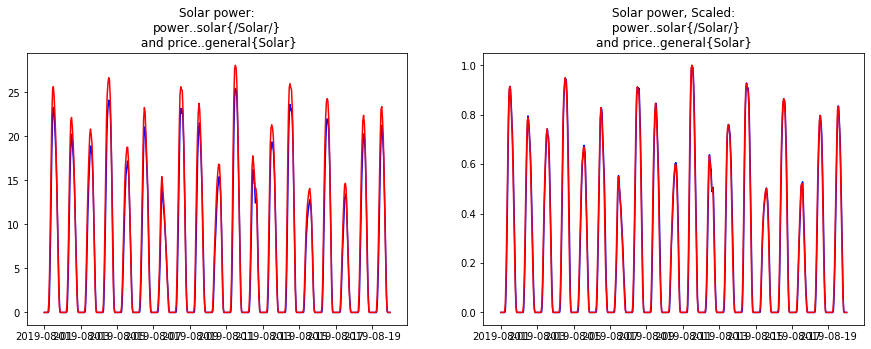

In [34]:
solarPowerP = res[list(res.keys())[0]]

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
ax1.plot(solarPower.index,solarPower.power,'b-')
ax1.plot(solarPowerP.index,solarPowerP.Solar,'r-')
ax1.set_title("Solar power:\npower..solar{/Solar/}\n and price..general{Solar}")

ax2.plot(solarPower.index,solarPower.power/solarPower.power.max(),'b-')
ax2.plot(solarPowerP.index,solarPowerP.Solar/solarPowerP.Solar.max(),'r-')
ax2.set_title("Solar power, Scaled:\n power..solar{/Solar/}\nand price..general{Solar}")
ax1.plot(); ax2.plot()

#Conclusion:  The solar power as used in the price..general database is a scaling of the combined sum 
# from the actual measured solar power.  The price..general database Solar data will be used, as it 
# also contains the forecast data...in the case the that the forecast must be adjusted.

## Evaluate the solar power as function of the solar radiation

In [35]:
#solarPowerPredict = solarPower[['power']].copy()
solarPower = solarPowerP.copy()
solarRadPowerFull = pd.DataFrame({'power': solarPower.Solar})

In [36]:
solarRadPowerFull = solarRadPowerFull.join(radPredict,how='outer')\
                                     .interpolate(limit_direction='both')

solarRadPowerFull = solarRadPowerFull.iloc[solarRadPowerFull.index.isin(radcalc.index)]

In [37]:
solarRadPowerFull.head()

,power,Bremen,Chemnitz,Fichtelberg,Furstenzell,Gorlitz,Hamburg,Hohenpeissenberg,Konstanz,Lindenberg,Norderney,Potsdam,Rostock,Saarbrucken,Schleswig,Seehausen,Trier,Wuerzburg
2019-08-01 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-08-01 00:15:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-08-01 00:30:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-08-01 00:45:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-08-01 01:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


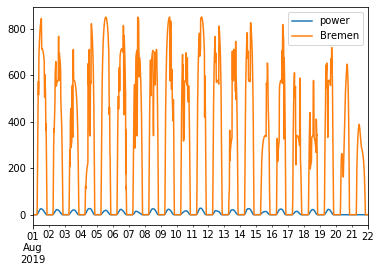

In [38]:
solarRadPowerFull[['power','Bremen']].plot()

In [39]:
solarRadPowerTrain   = solarRadPowerFull.iloc[solarRadPowerFull.index.isin(currIndex)]
solarRadPowerPredict = solarRadPowerFull.iloc[solarRadPowerFull.index.isin(foreIndex)]


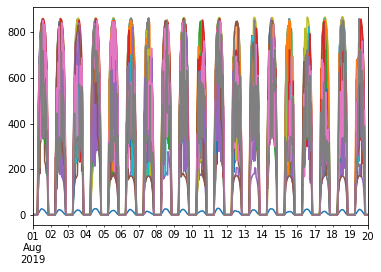

In [40]:
# solar radiation vs solar power for measured time span
solarRadPowerTrain.plot(legend=False)

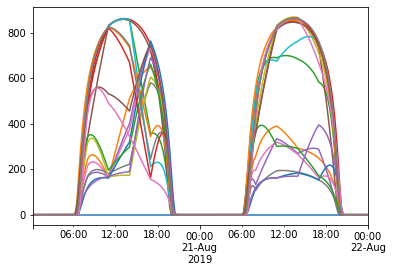

In [41]:
# solar radition for day ahead, (solar power not measured...that's why we predict)
solarRadPowerPredict.plot(legend=False)

---
- predict solar power
---

In [42]:
solarRadPowerTrain['timestamp'] = solarRadPowerTrain.index
solarRadPowerTrain.timestamp = solarRadPowerTrain.timestamp.apply(lambda x: x.timestamp())
solarRadPowerTrain.timestamp = solarRadPowerTrain.timestamp - solarRadPowerFull.index[0].timestamp()

In [43]:
solarRadPowerTrain.index[-1]

Timestamp('2019-08-20 00:00:00+0000', tz='UTC')

In [44]:
cols = [*cities,'timestamp']
reg= linear_model.LinearRegression()
reg.fit(X=solarRadPowerTrain[cols],y=solarRadPowerTrain.power)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Text(0, 0.5, 'Solar Power (GW)')

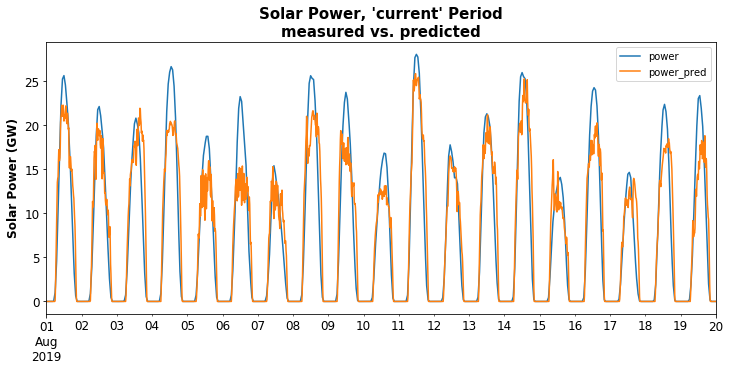

In [48]:
# check fit
solarRadPowerTrain['power_pred'] = reg.predict(solarRadPowerTrain[cols])
solarRadPowerTrain.power_pred.loc[solarRadPowerTrain.power_pred < 0] = 0

#plt.plot(solarRadPowerTrain.index,solarRadPowerTrain.power,'b-')
#plt.plot(solarRadPowerTrain.index,solarRadPowerTrain.power_pred,'r-')

solarRadPowerTrain[['power','power_pred']].plot(figsize=(12,5),fontsize=12)
plt.title("Solar Power, \'current\' Period\nmeasured vs. predicted",fontdict=titlefont)
plt.ylabel("Solar Power (GW)",fontdict=axisfont)

In [50]:
r2_score(solarRadPowerTrain.power,solarRadPowerTrain.power_pred)

0.8567566550944918

In [51]:
# predict the future solar power, add time variable for trend variance
solarRadPowerPredict['timestamp'] = solarRadPowerPredict.index
solarRadPowerPredict.timestamp = solarRadPowerPredict.timestamp.apply(lambda x: x.timestamp())
solarRadPowerPredict.timestamp = solarRadPowerPredict.timestamp - solarRadPowerFull.index[0].timestamp()

In [52]:
solarRadPowerPredict['power_pred'] = reg.predict(solarRadPowerPredict[cols])
solarRadPowerPredict.power_pred.loc[solarRadPowerPredict.power_pred < 0] = 0

Text(0, 0.5, 'Solar Power (GW)')

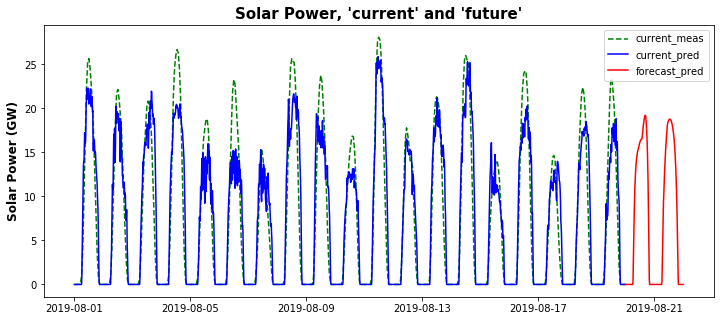

In [57]:
plt.figure(figsize=(12,5))
plt.plot(solarRadPowerTrain.index,solarRadPowerTrain.power,'g--',label='current_meas')
plt.plot(solarRadPowerTrain.index,solarRadPowerTrain.power_pred,'b-', label='current_pred')
plt.plot(solarRadPowerPredict.index,solarRadPowerPredict.power_pred,'r-', label='forecast_pred')
plt.title("Solar Power, \'current\' and \'future\'",fontdict=titlefont)
plt.legend(loc='upper right')
plt.ylabel("Solar Power (GW)",fontdict=axisfont)

--- 
commit to the database
---

In [58]:
solarPowerOutput = solarRadPowerTrain[['power','power_pred']].copy()
solarPowerOutput['power_meas'] = solarPowerOutput.power
solarPowerOutput = solarPowerOutput[['power','power_meas','power_pred']]

tmp = solarRadPowerPredict[['power_pred']].copy()
tmp['power'] = tmp.power_pred
tmp['power_meas'] = 0
tmp = tmp[['power','power_meas','power_pred']]


In [59]:
solarPowerOutput.tail()

,power,power_meas,power_pred
2019-08-19 23:00:00+00:00,0.0,0.0,0.0
2019-08-19 23:15:00+00:00,0.0,0.0,0.0
2019-08-19 23:30:00+00:00,0.0,0.0,0.0
2019-08-19 23:45:00+00:00,0.0,0.0,0.0
2019-08-20 00:00:00+00:00,0.0,0.0,0.0


In [60]:
tmp.head()

,power,power_meas,power_pred
2019-08-20 00:15:00+00:00,0.0,0,0.0
2019-08-20 00:30:00+00:00,0.0,0,0.0
2019-08-20 00:45:00+00:00,0.0,0,0.0
2019-08-20 01:00:00+00:00,0.0,0,0.0
2019-08-20 01:15:00+00:00,0.0,0,0.0


In [61]:
solarPowerOutput = solarPowerOutput.append(tmp)
#solarPowerOutput

In [62]:
res = clientDF.query("SHOW databases")

In [63]:
dbs = [ v['name'] for v in list(res)[0]]
dbs

['_internal',
 'power',
 'climate',
 'price',
 'currentWeather',
 'forecastWeather',
 'SolarWindEnergy']

In [64]:
outputDB = 'SolarWindEnergy'
if config.get('jupyter_SolarWindEnergy'):
    outputDB = config['jupyter_SolarWindEnergy'].get('outputDB') \
               if config['jupyter_SolarWindEnergy'].get('outputDB') else outputDB  # alternate specification

if outputDB not in dbs:
    clientDF.query(f'CREATE DATABASE {outputDB}')
    print(f'created database {outputDB}')
else:
    print(f'database {outputDB} already existed')

database SolarWindEnergy already existed


In [57]:
if commitToDB:
    clientDF.write_points(dataframe=solarPowerOutput,
                          database=outputDB,measurement='solar')
else:
    print("Commit to DB skipped")

 prediction of power complete, results sent to database

---
---
# Evaluate Wind Power
---

start and end times have been defined previously in the Solar Power section
query wind power from price..general database

In [65]:
# query the wind power from the price database

database = 'price..general'
res = clientDF.query(f"""SELECT Wind FROM {database}\
                         WHERE time >= '{startTime}' \
                         AND time <= '{endTime}'""")

In [66]:
windPower = res[list(res)[0]]
windPower = windPower.rename(columns={"Wind": "wind_power_meas"})


Text(0, 0.5, 'Wind Power (GW)')

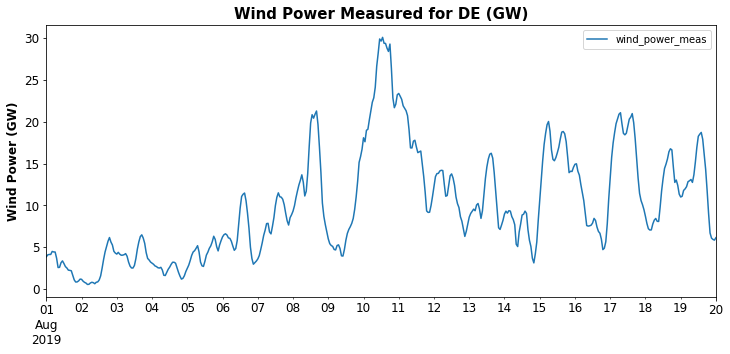

In [67]:
windPower.plot(figsize=(12,5),fontsize=12)
plt.title("Wind Power Measured for DE (GW)",fontdict=titlefont)
plt.ylabel("Wind Power (GW)",fontdict=axisfont)

## query current weather for 'windiness'

In [68]:
database = 'currentWeather'
res = clientDF.query(f"SHOW measurements on {database}") 


In [69]:
cities = [ v['name'][3:] for v in list(res)[0]]

In [70]:
citiesCSV = ",".join([ f'currentWeather.."wc-{ct}"' for ct in cities])
queryStatement = f"""\
 SELECT "wind_speed" FROM {citiesCSV} \
                     WHERE time >= '{startTime}' \
                     AND time <= '{endTime}'"""
print(queryStatement)

 SELECT "wind_speed" FROM currentWeather.."wc-Bremen",currentWeather.."wc-Chemnitz",currentWeather.."wc-Fichtelberg",currentWeather.."wc-Furstenzell",currentWeather.."wc-Gorlitz",currentWeather.."wc-Hamburg",currentWeather.."wc-Hohenpeissenberg",currentWeather.."wc-Konstanz",currentWeather.."wc-Lindenberg",currentWeather.."wc-Norderney",currentWeather.."wc-Potsdam",currentWeather.."wc-Rostock",currentWeather.."wc-Saarbrucken",currentWeather.."wc-Schleswig",currentWeather.."wc-Seehausen",currentWeather.."wc-Stuttgart",currentWeather.."wc-Trier",currentWeather.."wc-Wuerzburg"                      WHERE time >= '2019-08-01 00:00:00'                      AND time <= '2019-08-20 00:00:00'


In [71]:
#queryStatement = 'SELECT "wind_speed" FROM currentWeather.."wc-Bremen"'
res = clientDF.query(queryStatement)

In [72]:
windWeather = pd.DataFrame()
for ct in cities:
    dF = res['wc-' + ct]
    print(f"wc-{ct}: ",type(res['wc-' + ct]))
    if any(dF.get('wind_speed')):
        windWeather = windWeather.join(pd.DataFrame({ ct:dF.wind_speed}),how='outer')

wc-Bremen:  <class 'pandas.core.frame.DataFrame'>
wc-Chemnitz:  <class 'pandas.core.frame.DataFrame'>
wc-Fichtelberg:  <class 'pandas.core.frame.DataFrame'>
wc-Furstenzell:  <class 'pandas.core.frame.DataFrame'>
wc-Gorlitz:  <class 'pandas.core.frame.DataFrame'>
wc-Hamburg:  <class 'pandas.core.frame.DataFrame'>
wc-Hohenpeissenberg:  <class 'pandas.core.frame.DataFrame'>
wc-Konstanz:  <class 'pandas.core.frame.DataFrame'>
wc-Lindenberg:  <class 'pandas.core.frame.DataFrame'>
wc-Norderney:  <class 'pandas.core.frame.DataFrame'>
wc-Potsdam:  <class 'pandas.core.frame.DataFrame'>
wc-Rostock:  <class 'pandas.core.frame.DataFrame'>
wc-Saarbrucken:  <class 'pandas.core.frame.DataFrame'>
wc-Schleswig:  <class 'pandas.core.frame.DataFrame'>
wc-Seehausen:  <class 'pandas.core.frame.DataFrame'>
wc-Stuttgart:  <class 'pandas.core.frame.DataFrame'>
wc-Trier:  <class 'pandas.core.frame.DataFrame'>
wc-Wuerzburg:  <class 'pandas.core.frame.DataFrame'>


In [73]:
tempDF = pd.DataFrame({"blank":0},index=currIndex)
windPowerWeather = windWeather.copy().join(windPower,how='outer')
windPowerWeather = windPowerWeather.join(tempDF,how='outer').interpolate(limit_direction='both')
windPowerWeather = windPowerWeather.drop(columns=['blank'])
windPowerWeather = windPowerWeather.iloc[windPowerWeather.index.isin(currIndex)]

Text(0, 0.5, 'Wind Velocity (km/h)')

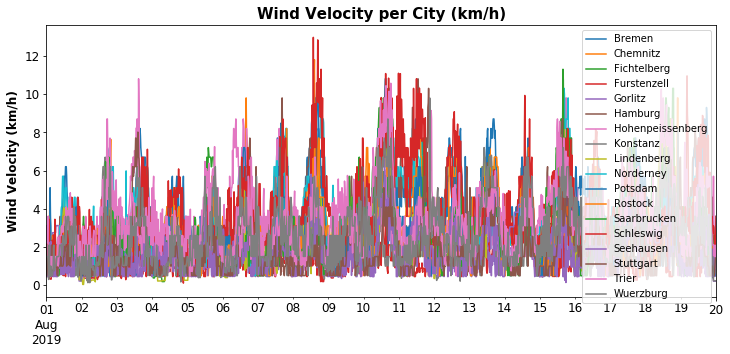

In [74]:
windPowerWeather[cities].plot(figsize=(12,5),fontsize=12)
plt.title("Wind Velocity per City (km/h)",fontdict=titlefont)
plt.ylabel("Wind Velocity (km/h)",fontdict=axisfont)

## predict current wind power from measurements

In [75]:
# determine the relationship between wind speed and power
windcols = cities
reg = linear_model.LinearRegression()

reg.fit(X=windPowerWeather[windcols],y=windPowerWeather.wind_power_meas)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [76]:
windPowerWeather['wind_power_pred'] = reg.predict(windPowerWeather[windcols])

Text(0, 0.5, 'Wind Power (GW)')

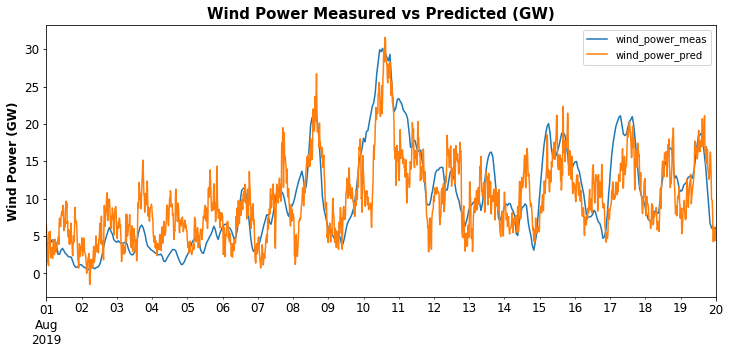

In [79]:
windPowerWeather[['wind_power_meas','wind_power_pred']].plot(figsize=(12,5),fontsize=12)
plt.title("Wind Power Measured vs Predicted (GW)",fontdict=titlefont)
plt.ylabel("Wind Power (GW)",fontdict=axisfont)

In [71]:
r2_score(windPowerWeather.wind_power_meas,windPowerWeather.wind_power_pred)

0.6392749510064482

---
## determine the future predicted wind power

In [80]:
# determine the future wind, take from the future time prediction 24 hours ahead
citiesCSV = ",".join([ f'forecastWeather.."wf-{ct}{faheadStr}"' for ct in cities])
queryStatement = f"""\
 SELECT "wind_speed" FROM {citiesCSV} \
                     WHERE time >= '{fstartTime}' \
                     AND time <= '{fendTime}'"""
print(queryStatement)


 SELECT "wind_speed" FROM forecastWeather.."wf-Bremen_-48",forecastWeather.."wf-Chemnitz_-48",forecastWeather.."wf-Fichtelberg_-48",forecastWeather.."wf-Furstenzell_-48",forecastWeather.."wf-Gorlitz_-48",forecastWeather.."wf-Hamburg_-48",forecastWeather.."wf-Hohenpeissenberg_-48",forecastWeather.."wf-Konstanz_-48",forecastWeather.."wf-Lindenberg_-48",forecastWeather.."wf-Norderney_-48",forecastWeather.."wf-Potsdam_-48",forecastWeather.."wf-Rostock_-48",forecastWeather.."wf-Saarbrucken_-48",forecastWeather.."wf-Schleswig_-48",forecastWeather.."wf-Seehausen_-48",forecastWeather.."wf-Stuttgart_-48",forecastWeather.."wf-Trier_-48",forecastWeather.."wf-Wuerzburg_-48"                      WHERE time >= '2019-08-20 00:00:00'                      AND time <= '2019-08-22 00:00:00'


In [81]:
#queryStatement = 'SELECT "wind_speed" FROM currentWeather.."wc-Bremen"'
res = clientDF.query(queryStatement)

In [82]:
windWeatherf = pd.DataFrame()
for ct in cities:
    dF = res[f"wf-{ct}{faheadStr}"]
    print(f"wf-{ct}{faheadStr}: ",type(res[f"wf-{ct}{faheadStr}"]))
    if any(dF.get('wind_speed')):
        windWeatherf = windWeatherf.join(pd.DataFrame({ ct:dF.wind_speed}),how='outer')

wf-Bremen_-48:  <class 'pandas.core.frame.DataFrame'>
wf-Chemnitz_-48:  <class 'pandas.core.frame.DataFrame'>
wf-Fichtelberg_-48:  <class 'pandas.core.frame.DataFrame'>
wf-Furstenzell_-48:  <class 'pandas.core.frame.DataFrame'>
wf-Gorlitz_-48:  <class 'pandas.core.frame.DataFrame'>
wf-Hamburg_-48:  <class 'pandas.core.frame.DataFrame'>
wf-Hohenpeissenberg_-48:  <class 'pandas.core.frame.DataFrame'>
wf-Konstanz_-48:  <class 'pandas.core.frame.DataFrame'>
wf-Lindenberg_-48:  <class 'pandas.core.frame.DataFrame'>
wf-Norderney_-48:  <class 'pandas.core.frame.DataFrame'>
wf-Potsdam_-48:  <class 'pandas.core.frame.DataFrame'>
wf-Rostock_-48:  <class 'pandas.core.frame.DataFrame'>
wf-Saarbrucken_-48:  <class 'pandas.core.frame.DataFrame'>
wf-Schleswig_-48:  <class 'pandas.core.frame.DataFrame'>
wf-Seehausen_-48:  <class 'pandas.core.frame.DataFrame'>
wf-Stuttgart_-48:  <class 'pandas.core.frame.DataFrame'>
wf-Trier_-48:  <class 'pandas.core.frame.DataFrame'>
wf-Wuerzburg_-48:  <class 'pandas.

In [83]:
tempDF = pd.DataFrame({"blank":0},index=foreIndex)
#windPowerWeatherf = windWeatherf.copy().join(windPower,how='outer')
windPowerWeatherf = windWeatherf.copy()
windPowerWeatherf['wind_power_meas'] = 0
windPowerWeatherf = windPowerWeatherf.join(tempDF,how='outer').interpolate(limit_direction='both')
windPowerWeatherf = windPowerWeatherf.drop(columns=['blank'])
windPowerWeatherf = windPowerWeatherf.iloc[windPowerWeatherf.index.isin(foreIndex)]

In [84]:
# utilize model predicted on current time frame (not future time frame)
windPowerWeatherf['wind_power_pred'] = reg.predict(windPowerWeatherf[windcols])

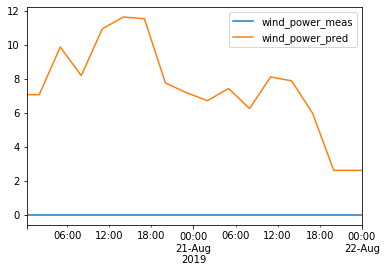

In [85]:
windPowerWeatherf[['wind_power_meas','wind_power_pred']].plot()

In [86]:
windPowerWeatherf[['wind_power_meas','wind_power_pred']].head()

,wind_power_meas,wind_power_pred
2019-08-20 00:15:00+00:00,0.0,7.058651
2019-08-20 00:30:00+00:00,0.0,7.058651
2019-08-20 00:45:00+00:00,0.0,7.058651
2019-08-20 01:00:00+00:00,0.0,7.058651
2019-08-20 01:15:00+00:00,0.0,7.058651


---
join future wind power prediction with original measurements


In [87]:
windPowerOutput = windPowerWeather[['wind_power_meas','wind_power_pred']].copy()
windPowerOutput = windPowerOutput.rename(columns={'wind_power_meas':'power_meas','wind_power_pred': 'power_pred'})
windPowerOutput['power'] = windPowerOutput.power_meas
windPowerOutput = windPowerOutput[['power','power_meas','power_pred']]

tmp = windPowerWeatherf[['wind_power_pred']].copy()
tmp = tmp.rename(columns={'wind_power_pred': 'power_pred'})
tmp['power'] = tmp.power_pred
tmp['power_meas'] = 0
tmp = tmp[['power','power_meas','power_pred']]

In [88]:
windPowerOutput.tail()

,power,power_meas,power_pred
2019-08-19 23:00:00+00:00,5.838000,5.838000,5.288520
2019-08-19 23:15:00+00:00,5.897384,5.897384,4.393339
2019-08-19 23:30:00+00:00,5.968644,5.968644,4.490260
2019-08-19 23:45:00+00:00,6.047822,6.047822,4.806229
2019-08-20 00:00:00+00:00,6.127000,6.127000,5.859865


In [89]:
tmp.head()

,power,power_meas,power_pred
2019-08-20 00:15:00+00:00,7.058651,0,7.058651
2019-08-20 00:30:00+00:00,7.058651,0,7.058651
2019-08-20 00:45:00+00:00,7.058651,0,7.058651
2019-08-20 01:00:00+00:00,7.058651,0,7.058651
2019-08-20 01:15:00+00:00,7.058651,0,7.058651


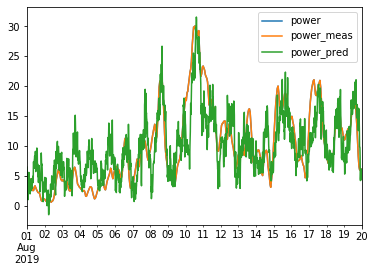

In [90]:
windPowerOutput.plot()

In [91]:
windPowerOutput = windPowerOutput.append(tmp)

In [92]:
# blend
windPowerOutput.power.loc[foreIndex[0]] = \
    (windPowerOutput.power.loc[currIndex[-1]] + windPowerOutput.power.loc[foreIndex[0]])/2

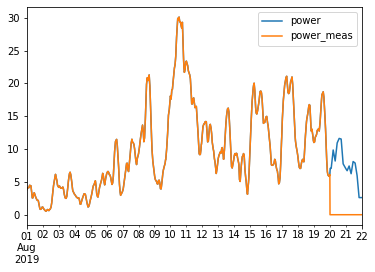

In [93]:
windPowerOutput[['power','power_meas']].plot()

Text(0, 0.5, 'Wind Power (GW)')

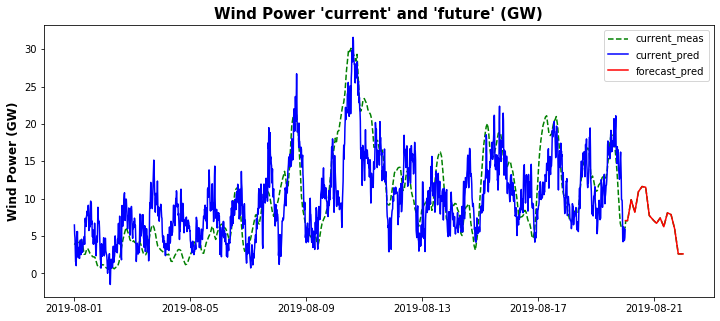

In [99]:
# for documenation
plt.figure(figsize=(12,5))
plt.plot(windPowerOutput.index,windPowerOutput.power,'g--',label='current_meas')
plt.plot(currIndex ,windPowerOutput.power_pred.loc[currIndex],'b-',label='current_pred')
plt.plot(foreIndex, windPowerOutput.power_pred.loc[foreIndex],'r-',label='forecast_pred')
plt.title("Wind Power \'current\' and \'future\' (GW)",fontdict=titlefont)
plt.legend(loc='upper right')
plt.ylabel("Wind Power (GW)",fontdict=axisfont)

---
## commit to database

In [100]:
res = clientDF.query("SHOW databases")
dbs = [ v['name'] for v in list(res)[0]]

In [87]:
#outputDB = 'SolarWindEnergy'  # already assigned
if outputDB not in dbs:
    clientDF.query(f'CREATE DATABASE {outputDB}')
    print(f'created database {outputDB}')
else:
    print(f'database {outputDB} already exists')

database SolarWindEnergy already exists


In [88]:
if commitToDB:
    clientDF.write_points(dataframe=windPowerOutput,
                          database=outputDB,measurement='wind')
else:
    print("Commit to database skipped")

# Evaluate power for selected plants

In [101]:
# build new dF with all power information

---
## Query current price and load

In [102]:
database = 'price..general'

# solar and wind data will be loaded from our DFs, current Load and price
fieldKeys = [ ("Load", "load"),
              ("Intraday Continuous Index Price", "price")] 

fieldString = ",".join([ '"' + fk + f'" as {rk}' for fk,rk in fieldKeys])

queryString = f'''select {fieldString} from {database}
                  where time >= \'{startTime}\' and time <= \'{endTime}\'
                        '''
print(queryString)

select "Load" as load,"Intraday Continuous Index Price" as price from price..general
                  where time >= '2019-08-01 00:00:00' and time <= '2019-08-20 00:00:00'
                        


In [103]:
res = clientDF.query(queryString)


In [104]:
dfPriceLoad = res[list(res.keys())[0]]

In [105]:
tmp = pd.DataFrame({"blank":0},index=currIndex)
dfPriceLoad = dfPriceLoad.join(tmp,how='outer').interpolate(limit_direction='both')
dfPriceLoad = dfPriceLoad.drop(columns=['blank'])

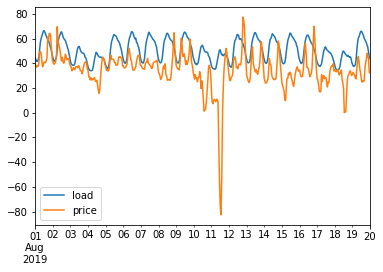

In [106]:
dfPriceLoad.plot()

---
## Query forecast price and load

In [107]:
# solar and wind data will be loaded from our DFs, future Load and price
fieldKeys = [ ("Load", "load"),
              ("Load forecast","fload"),
              ("Intraday Continuous Index Price", "price"),
              ("Day Ahead Auction", "fprice")] 

fieldString = ",".join([ '"' + fk + f'" as {rk}' for fk,rk in fieldKeys])

queryString = f'''select {fieldString} from {database}
                  where time >= \'{fstartTime}\' and time <= \'{fendTime}\'
                        '''
print(queryString)

select "Load" as load,"Load forecast" as fload,"Intraday Continuous Index Price" as price,"Day Ahead Auction" as fprice from price..general
                  where time >= '2019-08-20 00:00:00' and time <= '2019-08-22 00:00:00'
                        


In [108]:
res = clientDF.query(queryString)
dfPriceLoadf = res[list(res.keys())[0]]

In [109]:
for cl in ['load', 'fload', 'price', 'fprice']:
    if cl not in dfPriceLoadf.columns:
        dfPriceLoadf[cl] = np.nan

In [110]:
dfPriceLoadf.price.loc[dfPriceLoadf.price.isna()] = dfPriceLoadf.fprice.loc[dfPriceLoadf.price.isna()]
dfPriceLoadf.load.loc[dfPriceLoadf.load.isna()] = dfPriceLoadf.fload.loc[dfPriceLoadf.load.isna()]

In [111]:
dfPriceLoadf = dfPriceLoadf.drop(columns=['fload','fprice'])

In [112]:
tmp = pd.DataFrame({'blank':0},index=foreIndex)
dfPriceLoadf = dfPriceLoadf.join(tmp,how='outer').interpolate(limit_direction='both')
dfPriceLoadf = dfPriceLoadf.drop(columns=['blank'])

In [113]:
dfPriceLoad = dfPriceLoad.append(dfPriceLoadf.loc[dfPriceLoadf.index > dfPriceLoad.index[-1]])

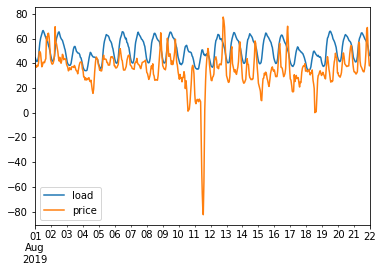

In [116]:
dfPriceLoad.plot()

Text(0.5, 1.0, 'Load and Energy Price')

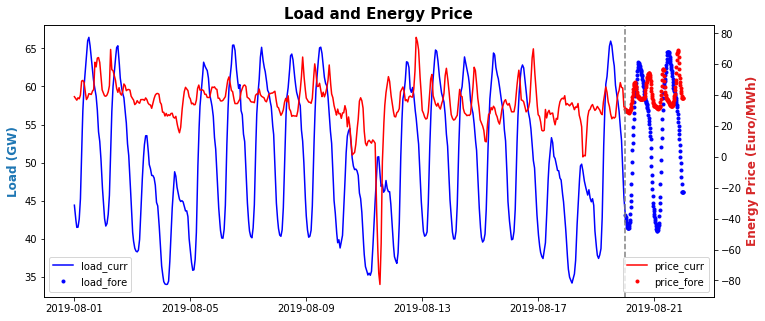

In [154]:
color1 = 'tab:blue'
color2 = 'tab:red'
fig, ax1= plt.subplots(figsize=(12,5))

ax1.set_ylabel('Load (GW)',size=12,weight='bold',color=color1)
ax1.plot(dfPriceLoad.loc[currIndex].index,dfPriceLoad.loc[currIndex].load,'b-',label='load_curr')
ax1.plot(dfPriceLoad.loc[foreIndex].index,dfPriceLoad.loc[foreIndex].load,'b.',label='load_fore')
ax1.legend(loc='lower left')

ax2 = ax1.twinx()
ax2.set_ylabel('Energy Price (Euro/MWh)',size=12,weight='bold',color=color2)
ax2.plot(dfPriceLoad.loc[currIndex].index,dfPriceLoad.loc[currIndex].price,'r-',label='price_curr')
ax2.plot(dfPriceLoad.loc[foreIndex].index,dfPriceLoad.loc[foreIndex].price,'r.',label='price_fore')
ax2.axvline(x=currIndex[-1],linestyle='--',color='grey')
ax2.legend(loc='lower right')

plt.title("Load and Energy Price",fontdict=titlefont)


## Build common DF for solar, wind, load and price

In [115]:
dfPriceLoadPower = dfPriceLoad.copy()
dfPriceLoadPower.price.loc[dfPriceLoadPower.price < 0] = 0   # strong penalty against excess power limited to 0
dfPriceLoadPower['solar'] = solarPowerOutput.power
dfPriceLoadPower['wind'] = windPowerOutput.power

dfPriceLoadPower['day'] = dfPriceLoadPower.index
dfPriceLoadPower.day = dfPriceLoadPower.day.apply(lambda x: cos((x.hour/24 + x.minute/60/24 )*2*pi))
dfPriceLoadPower['weekday'] = dfPriceLoadPower.index
dfPriceLoadPower.weekday = dfPriceLoadPower.weekday.apply(lambda x: x.weekday)
dfPriceLoadPower['isWeekend'] = 0
dfPriceLoadPower.isWeekend.loc[dfPriceLoadPower.weekday >= 5] = 1 

dfPriceLoadPower.head()

,load,price,solar,wind,day,weekday,isWeekend
2019-08-01 00:00:00+00:00,44.3970,38.970,0.0,3.845000,1.000000,3,0
2019-08-01 00:15:00+00:00,43.9825,38.675,0.0,3.905384,0.997859,3,0
2019-08-01 00:30:00+00:00,43.5680,38.380,0.0,3.965767,0.991445,3,0
2019-08-01 00:45:00+00:00,43.1535,38.085,0.0,4.026151,0.980785,3,0
2019-08-01 01:00:00+00:00,42.7390,37.790,0.0,4.077000,0.965926,3,0


Text(0, 0.5, 'Power (GW), Price(Euro/MWh)')

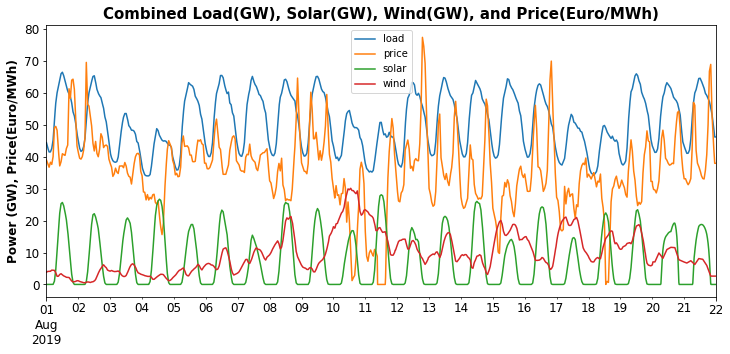

In [104]:
dfPriceLoadPower[['load','price','solar','wind']].plot(figsize=(12,5),fontsize=12)
plt.title("Combined Load(GW), Solar(GW), Wind(GW), and Price(Euro/MWh)",fontdict=titlefont)
plt.ylabel("Power (GW), Price(Euro/MWh)",fontdict=axisfont)

Text(0, 0.5, 'isWeekend, day cycle (-)')

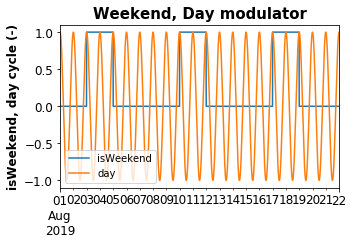

In [105]:
dfPriceLoadPower[['isWeekend','day']].plot(figsize=(5,3),fontsize=12)
plt.title("Weekend, Day modulator",fontdict=titlefont)
plt.ylabel("isWeekend, day cycle (-)",fontdict=axisfont)

## Query plant power for selected plants

In [106]:
database = 'power..gas'

In [107]:
fieldKeys = ['/München/', '/Knapsack/']
if config.get('jupyter_SolarWindEnergy') and config['jupyter_SolarWindEnergy'].get('PredictPlantPower'):
    fieldKeys = config['jupyter_SolarWindEnergy']['PredictPlantPower'].get('plantQueryStrings') \
                if config['jupyter_SolarWindEnergy']['PredictPlantPower'].get('plantQueryStrings') \
                else fieldKeys

queryString = f'''select {",".join(fieldKeys)} from {database}
                  where time >= \'{startTime}\' and time <= \'{endTime}\'
                        '''
print(queryString)

select /München/,/Knapsack/ from power..gas
                  where time >= '2019-08-01 00:00:00' and time <= '2019-08-20 00:00:00'
                        


In [108]:
res = clientDF.query(queryString)

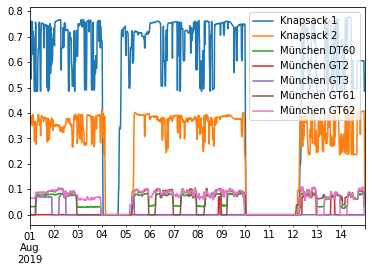

In [109]:
dfGas = res[list(res.keys())[0]]
dfGas.plot()

In [110]:
# readjust the current and future times based on the power
pStartTime= startTime
pendTime = dfGas.index[-1]

In [111]:
pcurrIndex = radcalc.index[radcalc.index <= pendTime ]
pforeIndex = radcalc.index[radcalc.index > pendTime]

In [112]:
plantNames=(pn for pn in res[list(res.keys())[0]].columns)  # make generator of columns

---
## iterate

In [393]:
plantName=next(plantNames)
print(plantName)

StopIteration: 

In [354]:
df = pd.DataFrame({"power":dfGas[plantName]})

In [355]:
maxPower = df.power.max()
running = df.loc[ df.power > maxPower*0.5]
df['running'] = 0
df.running.loc[running.index] = 1 
minPower = df.power.loc[df.running > 0].min()

df['baseLoad'] = 0
df['lowLoad'] = 0
df.baseLoad.loc[df.power > (maxPower - minPower)/2 + minPower] = 1
df.lowLoad.loc[df.power < (maxPower - minPower) /2 + minPower] = 1
df.lowLoad.loc[df.running == 0 ] = 0

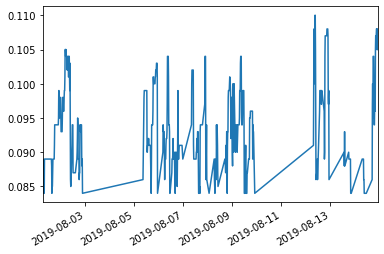

In [356]:
df.power.loc[df.baseLoad > 0].plot()

In [357]:
dfRun = df.copy()
dfRun = dfRun.join(dfPriceLoadPower,how='outer')
dfRun = dfRun.join(pd.DataFrame({'blank':0},index=pcurrIndex)).interpolate(limit_direction='both')  # mod
dfRun = dfRun.drop(columns=['blank'])
dfRun = dfRun.loc[pcurrIndex]

dfRun['geld'] = dfRun.power*dfRun.price*1000  # production income for operation ( GW * Euro/MWh * 1000 MW/GW)

minRunPower = dfRun.power.loc[dfRun.running > 0].min()
minRunPower


0.057

Text(0, 0.5, 'GT Power (GW)')

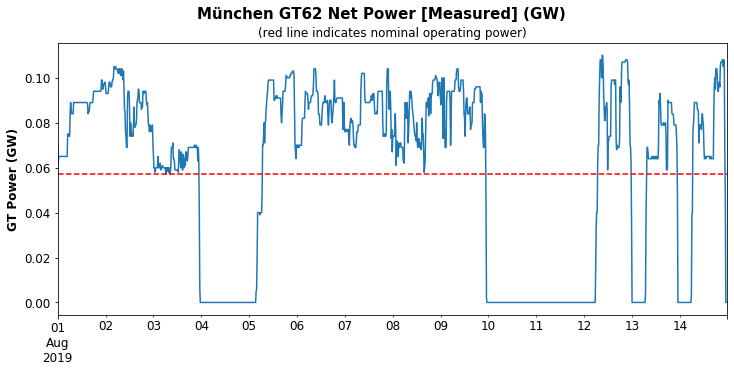

In [358]:
dfRun.power.plot(figsize=(12,5),fontsize=12)
plt.axhline(y=minRunPower,color='red',linestyle='--')
plt.title("(red line indicates nominal operating power)",fontdict={'size':12,'weight':'normal'})
plt.suptitle(f"{plantName} Net Power [Measured] (GW)",fontsize=15,weight='bold')
plt.ylabel("GT Power (GW)",fontdict=axisfont)

In [359]:
regressorCol = 'power'
#regressCols = ['load','price','solar','wind','day','weekday']
regressCols = ['load','price','solar','wind','day','isWeekend']
#regressCols = ['load','price','solar','wind']
#indices = dfRun.index[dfRun.running > 0]
indices = dfRun.index

In [360]:
reg = linear_model.LinearRegression()

X = dfRun[regressCols].loc[indices]
y = dfRun[regressorCol].loc[indices]

reg.fit(X=X,y=y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [361]:
dfRun['power_pred'] = reg.predict(dfRun[regressCols])

Text(0, 0.5, 'GT Power (GW)')

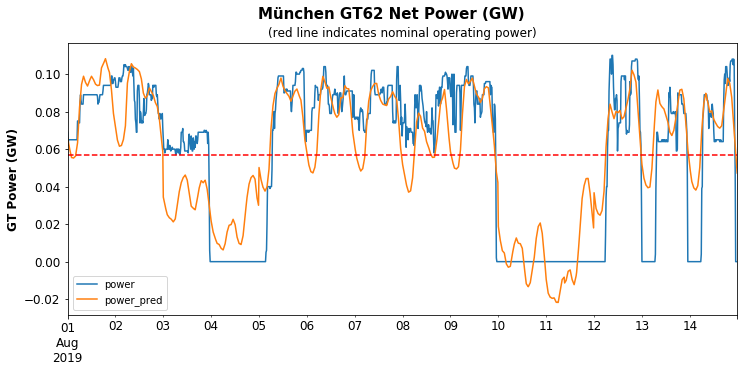

In [362]:
dfRun[['power','power_pred']].iloc[:].plot(figsize=(12,5),fontsize=12)
plt.axhline(y=minRunPower,color='red',linestyle='--')
plt.title("(red line indicates nominal operating power)",fontdict={'size':12,'weight':'normal'})
plt.suptitle(f"{plantName} Net Power (GW)",fontsize=15,weight='bold')
plt.ylabel("GT Power (GW)",fontdict=axisfont)

In [363]:
r2_score(dfRun.power,dfRun.power_pred)

0.7052569131647535

In [364]:
dfRun['running_pred'] = 0
dfRun.running_pred.loc[dfRun.power_pred > minRunPower] = 1

Text(0, 0.5, 'isRunning = 1')

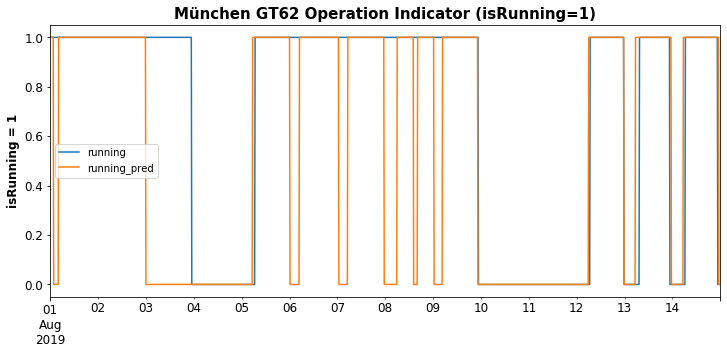

In [365]:
dfRun[['running','running_pred']].plot(figsize=(12,5),fontsize=12)
plt.title(f"{plantName} Operation Indicator (isRunning=1)",fontdict=titlefont)
plt.ylabel("isRunning = 1",fontdict=axisfont)

In [366]:
accuracy_score(dfRun.running,dfRun.running_pred)

0.8392857142857143

In [367]:
def refineMinRunPower(minRP):
    dfRun['running_pred'] = 0
    dfRun.running_pred.loc[dfRun.power_pred > minRP] = 1
    accuracy = accuracy_score(dfRun.running,dfRun.running_pred)
    
    return accuracy

In [368]:
dfOptimize = pd.DataFrame({"x": np.linspace(0.0*maxPower, maxPower,num=50), 
                           "y": np.zeros(shape=50)})
dfOptimize.y = dfOptimize.x.apply(refineMinRunPower)

In [369]:
bestMinRunPower = dfOptimize.x.loc[dfOptimize.y == dfOptimize.y.max()].min()
bestMinRunPower

0.047142857142857146

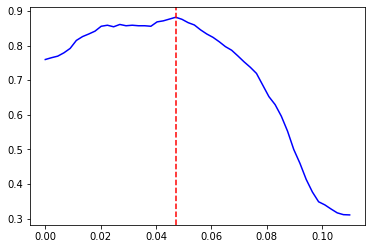

In [370]:
plt.plot(dfOptimize.x,dfOptimize.y,'b-')
plt.axvline(x=[bestMinRunPower],color='red',linestyle='--')

In [371]:
# retry around the optimimum with a smaller interval
dfOptimize = pd.DataFrame({"x": np.linspace(bestMinRunPower-maxPower/10, bestMinRunPower+maxPower/10,num=50), 
                           "y": np.zeros(shape=50)})
dfOptimize.y = dfOptimize.x.apply(refineMinRunPower)
bestMinRunPower = dfOptimize.x.loc[dfOptimize.y == dfOptimize.y.max()].min()

print(f"minimum revenue level for on/off status: {bestMinRunPower}")
print(f"accuracy ={refineMinRunPower(bestMinRunPower)}")

minimum revenue level for on/off status: 0.04736734693877551
accuracy =0.8816964285714286


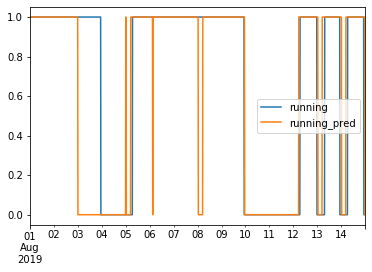

In [372]:
dfRun[['running','running_pred']].plot()

---
An attempt to clean up the holes in the prediction...did not work.
It actually makes it worse

In [373]:
#isOff = dfRun.index[dfRun.running == 0]
#incDiff = dfRun.index[1]-dfRun.index[0]

In [374]:
#minTimes = []
#t1 = isOff[0]
#for i in range(1,len(isOff)):
#    if isOff[i] - isOff[i-1] > incDiff:
#        tdiff = isOff[i-1] - t1
#        minTimes.append(tdiff)
#        t1 = isOff[i]

#minOffTime = min(minTimes)
#print(minOffTime)

In [375]:
#minOffTime = timedelta(minutes=30)

In [376]:
## fix the predicted times, which were not really off times
#isOff = dfRun.index[dfRun.running_pred == 0]

In [377]:
#minTimes = []
#t1 = isOff[0]
#for i in range(1,len(isOff)):
#    if isOff[i] - isOff[i-1] > incDiff:
#        tdiff = isOff[i-1] - t1
#        minTimes.append((tdiff,t1,isOff[i-1]))
#        t1 = isOff[i]

In [378]:
#minTimes

In [379]:
#for mt,t1,t2 in minTimes:
#    if mt < minOffTime:
#        dfRun.running_pred[np.logical_and(dfRun.index >= t1,dfRun.index <= t2)] = 1

In [380]:
##  actually, looks worse --> don't use this way
#dfRun[['running','running_pred']].plot()

## Create prediction of future runs

In [381]:
dfRunf = dfPriceLoadPower[regressCols].loc[pforeIndex].copy()

In [382]:
# use previously fitted model
dfRunf['power_pred'] = reg.predict(dfRunf[regressCols])

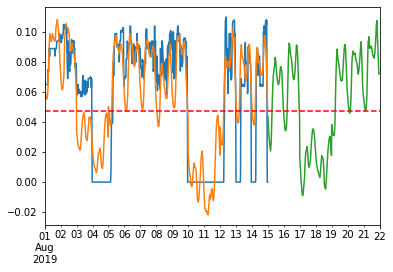

In [383]:
dfRun.power.plot()
dfRun.power_pred.plot()
dfRunf.power_pred.plot()
plt.axhline(y=bestMinRunPower,color='red',linestyle='--')

In [384]:
dfRunOutput = dfRun[['power','power_pred']].copy()
dfRunOutput['power_meas'] = dfRunOutput.power
dfRunOutput = dfRunOutput[['power','power_meas','power_pred']]

tmp = dfRunf[['power_pred']].copy()
tmp['power'] = tmp.power_pred
tmp['power_meas'] = 0
tmp = tmp[['power','power_meas','power_pred']]

In [385]:
dfRunOutput.tail()

,power,power_meas,power_pred
2019-08-14 22:45:00+00:00,0.049,0.049,0.061576
2019-08-14 23:00:00+00:00,0.000,0.000,0.057744
2019-08-14 23:15:00+00:00,0.000,0.000,0.054273
2019-08-14 23:30:00+00:00,0.000,0.000,0.050777
2019-08-14 23:45:00+00:00,0.000,0.000,0.047255


In [386]:
tmp.head()

,power,power_meas,power_pred
2019-08-15 00:00:00+00:00,0.043708,0,0.043708
2019-08-15 00:15:00+00:00,0.041438,0,0.041438
2019-08-15 00:30:00+00:00,0.039143,0,0.039143
2019-08-15 00:45:00+00:00,0.036822,0,0.036822
2019-08-15 01:00:00+00:00,0.034476,0,0.034476


In [387]:
dfRunOutput = dfRunOutput.append(tmp)

In [388]:
dfRunOutput['running'] = 0
dfRunOutput.running.loc[dfRunOutput.power > bestMinRunPower] = 1
dfRunOutput['running_meas'] = dfRunOutput.running
dfRunOutput.running_meas.loc[dfRunOutput.index > pendTime] = 0
dfRunOutput['running_pred'] = dfRunOutput.running
dfRunOutput.running_pred.loc[dfRunOutput.index <= pendTime] = 0


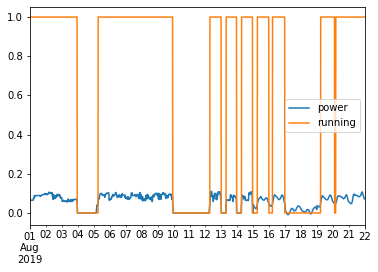

In [389]:
dfRunOutput[['power','running']].plot()

## commit to database

In [390]:
res = clientDF.query("SHOW databases")
dbs = [ v['name'] for v in list(res)[0]]

In [391]:
#outputDB = 'SolarWindEnergy'  # already assigned
if outputDB not in dbs:
    clientDF.query(f'CREATE DATABASE {outputDB}')
    print(f'created database {outputDB}')
else:
    print(f'database {outputDB} already exists')

database SolarWindEnergy already exists


In [392]:
if commitToDB:
    clientDF.write_points(dataframe=dfRunOutput,
                          database=outputDB,measurement=plantName)
    print("Points commited to database")
else:
    print("Commit to database skipped")

Points commited to database
